# Second Laboratory
### Group "Trap" - Data Science for Business 2022

In this notebook we will load the dataset created during the first laboratory, in order to do some time series analysis.

At the end we will prepare the dataset for ML algorithms by encoding categorical values into numeric ones.

In [1]:
# Remember the trailing slash
data_path = "~/data/"

import pandas as pd
jobs = pd.read_csv(data_path + "Cleaned_Jobs.csv", index_col=[0])

/home/mirko/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<AxesSubplot:xlabel='ANNO,MESE'>

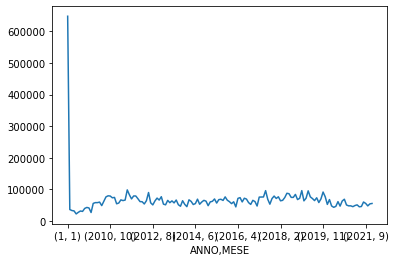

In [7]:
jobs.where["ANNO" > 2010.groupby(["ANNO", "MESE"]).size().plot()

In [66]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def get_ac(ts):
    # Calculate ACF and PACF upto 50 lags
    # acf_50 = acf(df.value, nlags=50)
    # pacf_50 = pacf(df.value, nlags=50)

    # Draw Plot
    fig, axes = plt.subplots(1,2,figsize=(20,6), dpi= 120)
    plot_acf(ts.to_list(), lags=50, ax=axes[0])
    plot_pacf(ts.to_list(), lags=50, ax=axes[1])
    plt.show()

## Looking for seasonality

Checking autocorrelation it seems like the data has no particular seasonality... 

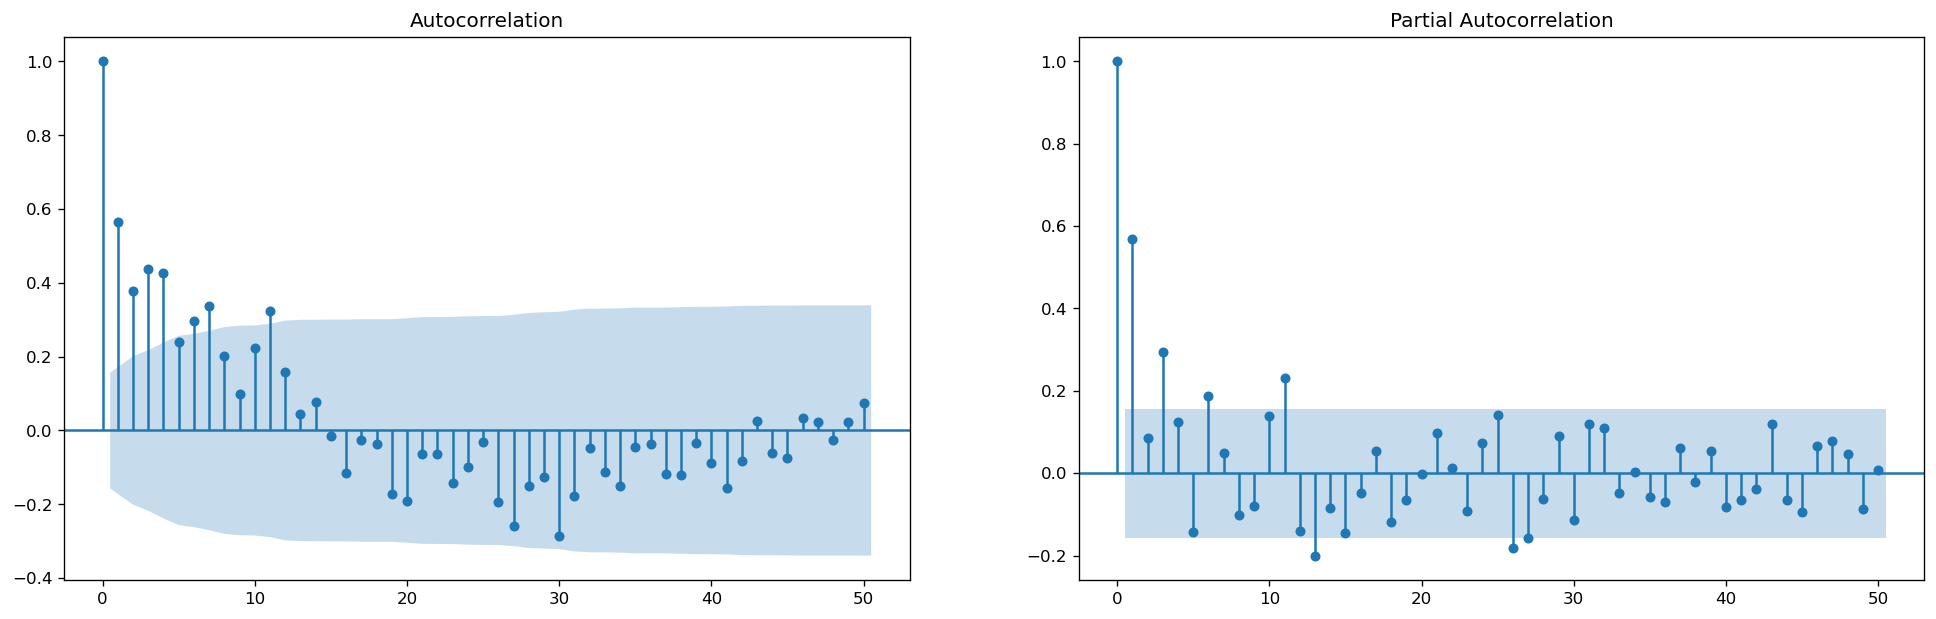

In [11]:
get_ac(jobs.groupby(["ANNO", "MESE"]).size())

... this is particularly true if we look at TEMPO INDETERMINATO contracts.

If we look at TEMPO DETERMINATO contracts instead we can see how seasonality is much more evident.

TEMPO INDETERMINATO


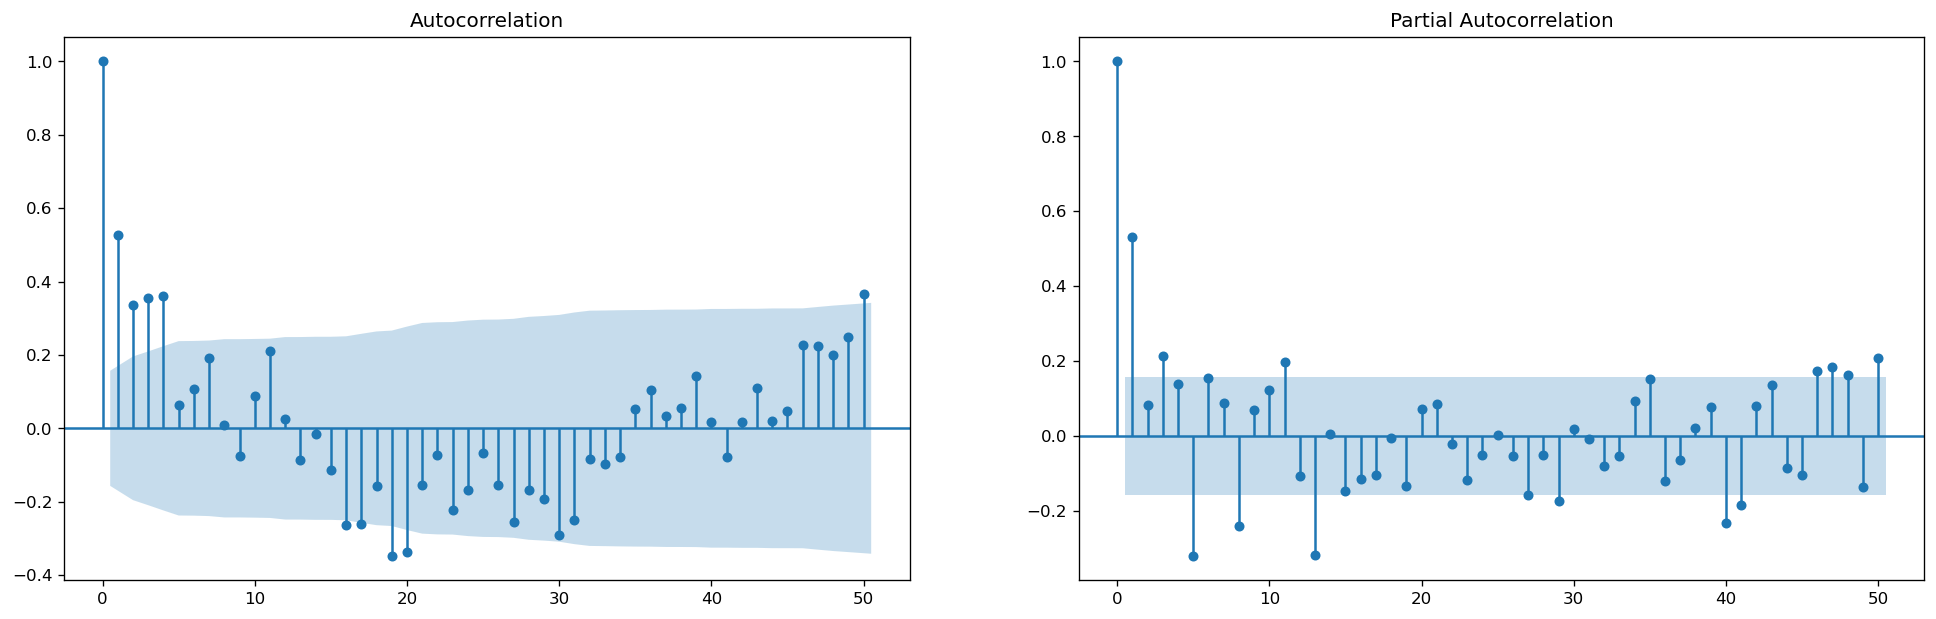


TEMPO DETERMINATO


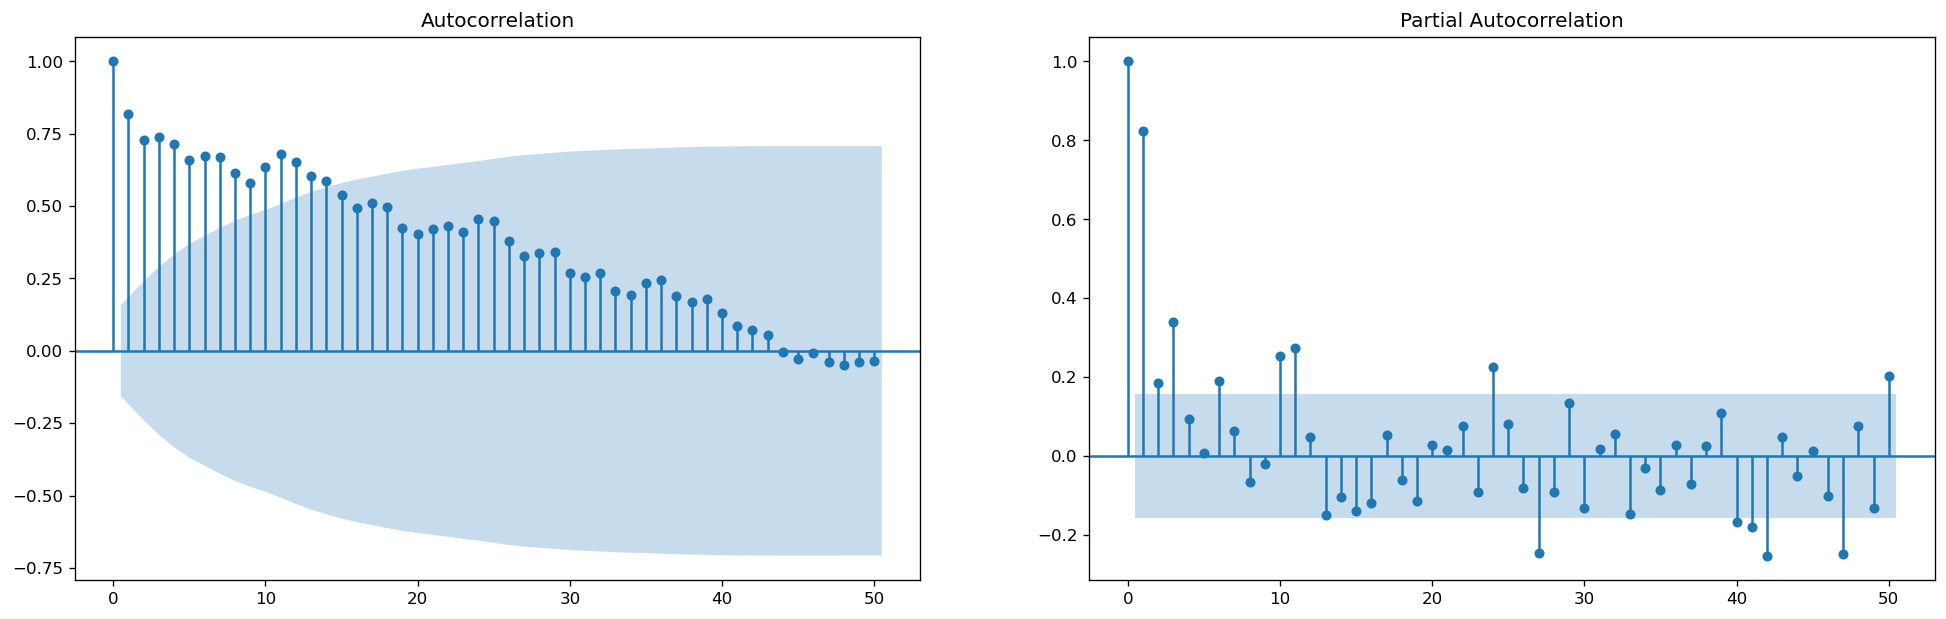

In [23]:
print("TEMPO INDETERMINATO")
get_ac(jobs.groupby(["ANNO", "MESE", "CONTRATTO"]).size().unstack()["TEMPO INDETERMINATO"])

print()
print("TEMPO DETERMINATO")
get_ac(jobs.groupby(["ANNO", "MESE", "CONTRATTO"]).size().unstack()["TEMPO DETERMINATO"])

This is probably even more evident if we look at TEMPO DETERMINATO contracts for hotels and similar activities (Ateco code 55.xx.xx)

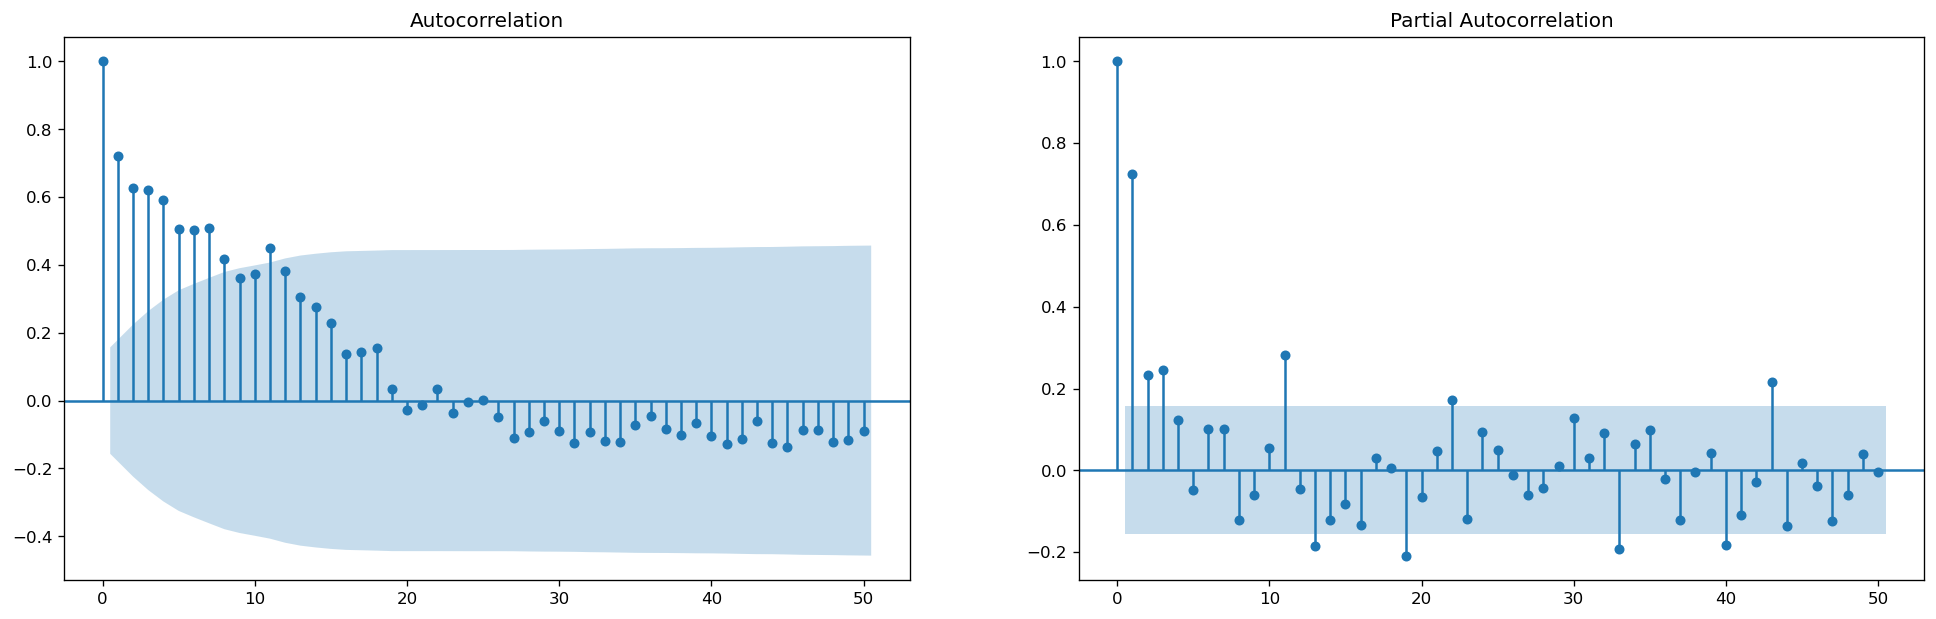

In [25]:
get_ac(jobs.groupby(["ANNO", "MESE", "CONTRATTO", "Ateco1"]).size().unstack()[55].unstack()["TEMPO DETERMINATO"])

Seasonality of TEMPO DETERMINATO as opposed to TEMPO INDETERMINATO contracts is pretty visible when plotting the time series.

<AxesSubplot:xlabel='ANNO,MESE'>

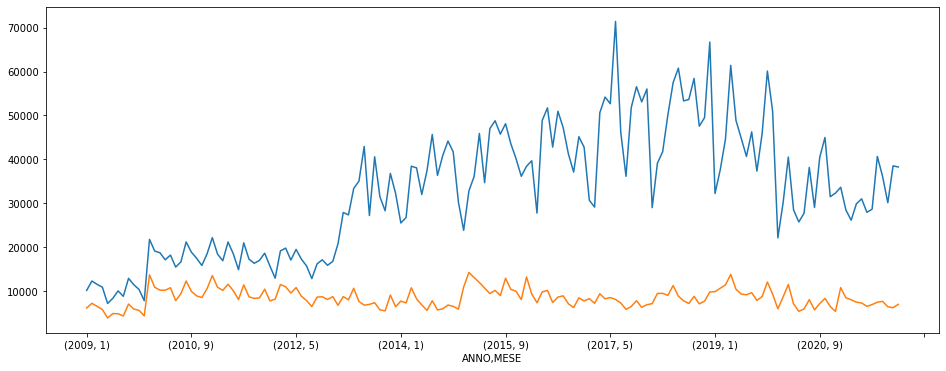

In [32]:
plt.figure(figsize=(16,6))
jobs.groupby(["ANNO", "MESE", "CONTRATTO"]).size().unstack()["TEMPO DETERMINATO"].plot()
jobs.groupby(["ANNO", "MESE", "CONTRATTO"]).size().unstack()["TEMPO INDETERMINATO"].plot()

## Decomposing the time serie

From the above plot we can also see how TEMPO DETERMINATO contract have become more popular after 2013 (this year coincides with a change of regulations on job contracts). Let's try to investigate it.

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

def seas_dec(ts):
    # Multiplicative Decomposition 
    result_mul = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq')

    # Additive Decomposition
    result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')

    # Plot
    plt.rcParams.update({'figure.figsize': (10,10)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
    result_add.plot().suptitle('Additive Decompose', fontsize=22)
    plt.show()

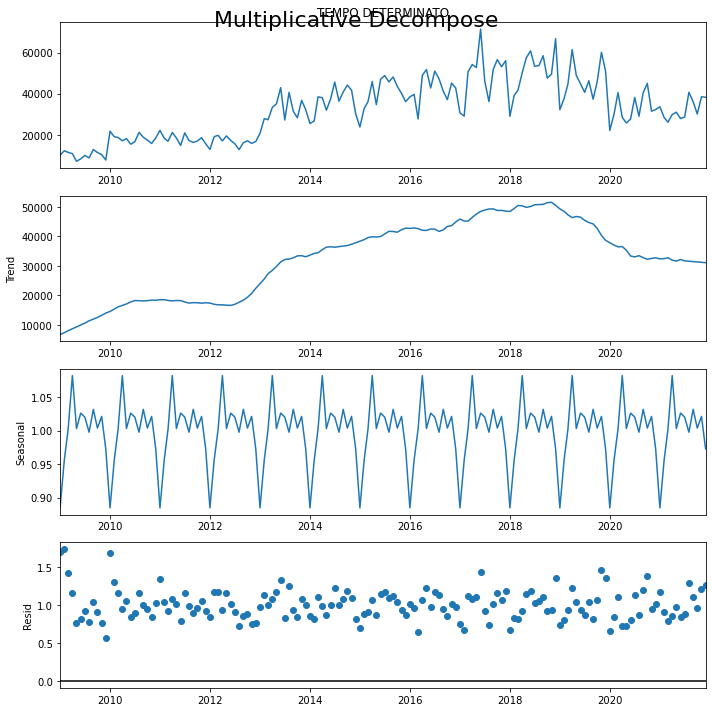

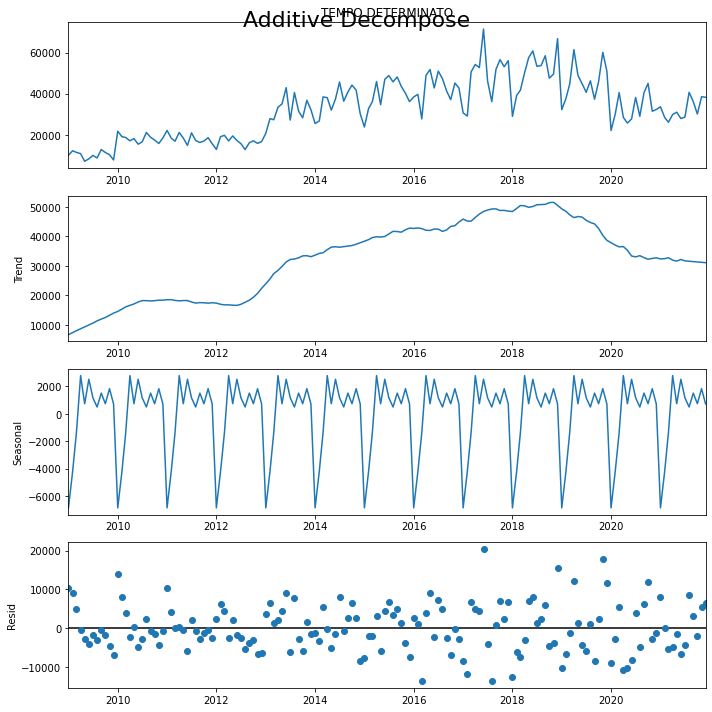

In [75]:
det_ts = jobs.groupby(["ANNO", "MESE", "CONTRATTO"]).size().unstack()["TEMPO DETERMINATO"].reset_index()
det_ts["DATA"] = det_ts["ANNO"].astype(str) + "/" + det_ts["MESE"].astype(str) + "/01"
det_ts["DATA"] = pd.to_datetime(det_ts["DATA"])
det_ts = det_ts.set_index("DATA")["TEMPO DETERMINATO"]
seas_dec(det_ts)

It's also interesting to do it for TEMPO INDETERMINATO contracts...

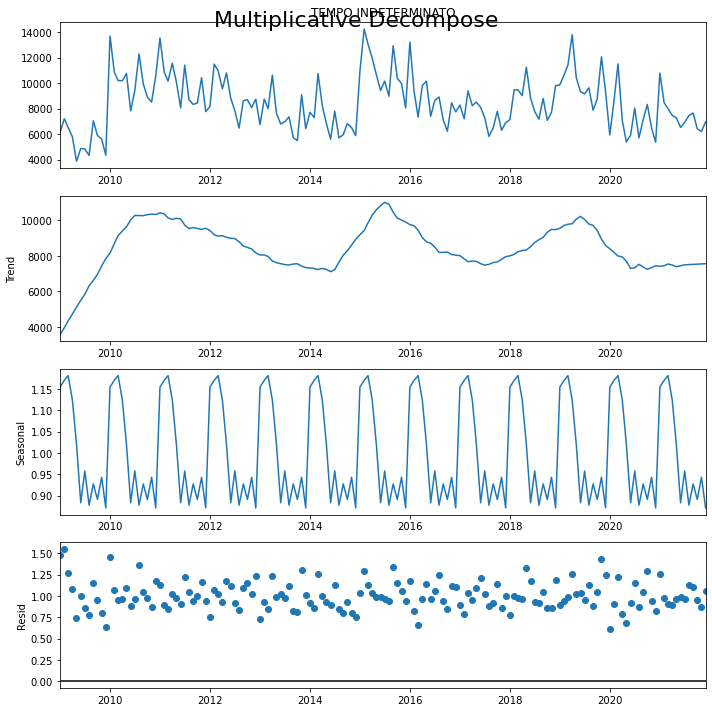

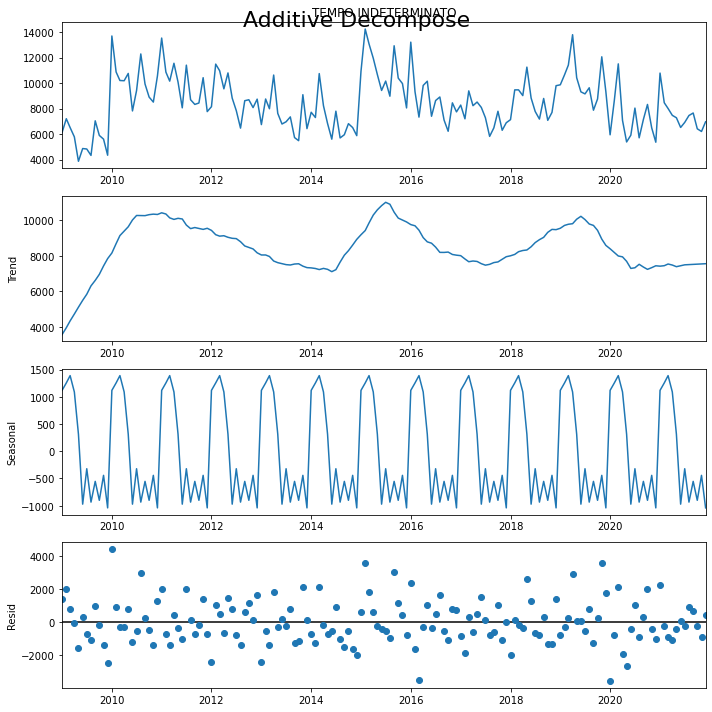

In [76]:
det_ts = jobs.groupby(["ANNO", "MESE", "CONTRATTO"]).size().unstack()["TEMPO INDETERMINATO"].reset_index()
det_ts["DATA"] = det_ts["ANNO"].astype(str) + "/" + det_ts["MESE"].astype(str) + "/01"
det_ts["DATA"] = pd.to_datetime(det_ts["DATA"])
det_ts = det_ts.set_index("DATA")["TEMPO INDETERMINATO"]
seas_dec(det_ts)

... and also for the general time series.

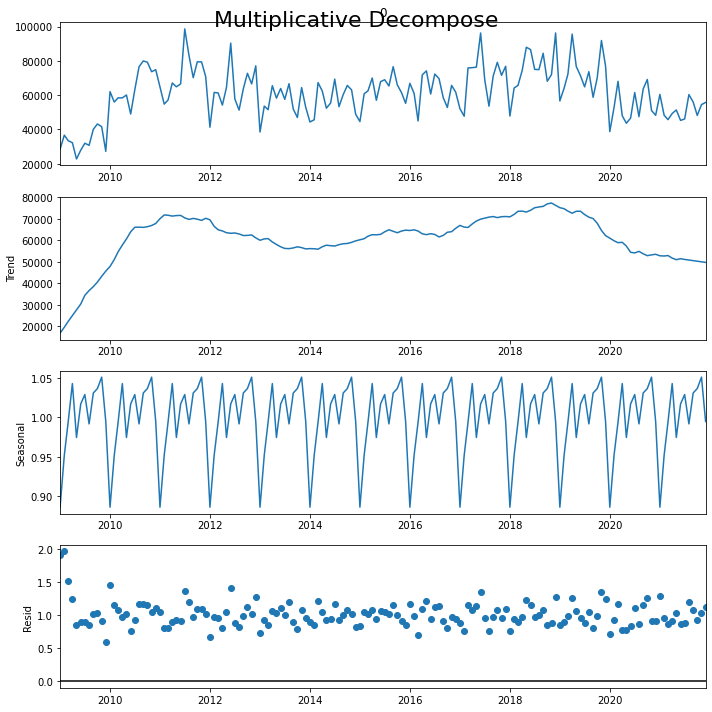

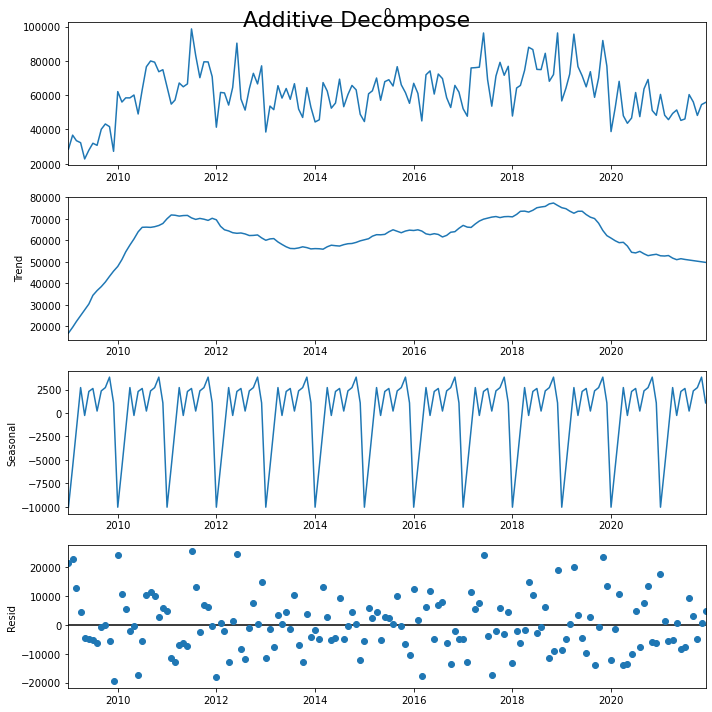

In [79]:
det_ts = jobs.groupby(["ANNO", "MESE"]).size().reset_index()
det_ts["DATA"] = det_ts["ANNO"].astype(str) + "/" + det_ts["MESE"].astype(str) + "/01"
det_ts["DATA"] = pd.to_datetime(det_ts["DATA"])
det_ts = det_ts.set_index("DATA")[0]
seas_dec(det_ts)

## Encoding categorical values

First we encode all categorical columns by using a one hot encoding.

In [3]:
encoded_jobs = pd.get_dummies(jobs, drop_first=True)
encoded_jobs

ETA  Ateco1  MESE  ANNO  GENERE_M  ISTRUZIONE_SCONOSCIUTO  \
1656      41      97     1  2009         0                       1   
1657      48      97     1  2009         1                       1   
1658      43      97     1  2009         0                       1   
1659      49      97     1  2009         0                       1   
1660      36      97     1  2009         0                       1   
...      ...     ...   ...   ...       ...                     ...   
9579788   29      94    12  2021         1                       0   
9579789   30      10    12  2021         0                       0   
9579790   25      82    12  2021         1                       0   
9579791   60      59    12  2021         1                       1   
9579792   23      88    12  2021         0                       0   

         ISTRUZIONE_SECONDARIA INFERIORE  ISTRUZIONE_SECONDARIA SUPERIORE  \
1656                                   0                                0   
1657                                   0                                0   
1658                                   0                                0   
1659                                   0                                0   
1660                                   0                                0   
...                                  ...                              ...   
9579788                                0                                1   
9579789                                1                                0   
9579790                                0                                1   
9579791                                0                                0   
9579792                                0                                0   

         ISTRUZIONE_TERZIARIA  CONTRATTO_TEMPO DETERMINATO  ...  \
1656                        0                            0  ...   
1657                        0                            0  ...   
1658                        0                            0  ...   
1659                        0                            0  ...   
1660                        0                            0  ...   
...                       ...                          ...  ...   
9579788                     0                            1  ...   
9579789                     0                            1  ...   
9579790                     0                            0  ...   
9579791                     0                            1  ...   
9579792                     1                            1  ...   

         PROVINCIAIMPRESA_CREMONA  PROVINCIAIMPRESA_LECCO  \
1656                            0                       0   
1657                            0                       0   
1658                            0                       0   
1659                            0                       0   
1660                            0                       0   
...                           ...                     ...   
9579788                         0                       0   
9579789                         0                       0   
9579790                         0                       0   
9579791                         0                       0   
9579792                         1                       0   

         PROVINCIAIMPRESA_LODI  PROVINCIAIMPRESA_MANTOVA  \
1656                         0                         0   
1657                         0                         0   
1658                         0                         0   
1659                         0                         0   
1660                         0                         0   
...                        ...                       ...   
9579788                      0                         0   
9579789                      0                         0   
9579790                      0                         0   
9579791                      0                         0   
9579792                      0               

The Ateco1 column was not encoded by the previous command since it is a numerical value. Given that it's a categorical feature I want to encode it, but I don't want to use a one hot encoding since we have nearly a hundred categories. We use a binary encoder instead

In [4]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['Ateco1'], return_df=True)
encoded_jobs = encoder.fit_transform(encoded_jobs) 
encoded_jobs

ETA  Ateco1_0  Ateco1_1  Ateco1_2  Ateco1_3  Ateco1_4  Ateco1_5  \
1656      41         0         0         0         0         0         0   
1657      48         0         0         0         0         0         0   
1658      43         0         0         0         0         0         0   
1659      49         0         0         0         0         0         0   
1660      36         0         0         0         0         0         0   
...      ...       ...       ...       ...       ...       ...       ...   
9579788   29         0         1         1         1         1         0   
9579789   30         0         0         0         0         0         1   
9579790   25         0         0         1         0         1         1   
9579791   60         0         0         0         1         0         1   
9579792   23         0         0         1         1         1         0   

         Ateco1_6  MESE  ANNO  ...  PROVINCIAIMPRESA_CREMONA  \
1656            1     1  2009  ...                         0   
1657            1     1  2009  ...                         0   
1658            1     1  2009  ...                         0   
1659            1     1  2009  ...                         0   
1660            1     1  2009  ...                         0   
...           ...   ...   ...  ...                       ...   
9579788         1    12  2021  ...                         0   
9579789         0    12  2021  ...                         0   
9579790         0    12  2021  ...                         0   
9579791         0    12  2021  ...                         0   
9579792         0    12  2021  ...                         1   

         PROVINCIAIMPRESA_LECCO  PROVINCIAIMPRESA_LODI  \
1656                          0                      0   
1657                          0                      0   
1658                          0                      0   
1659                          0                      0   
1660                          0                      0   
...                         ...                    ...   
9579788                       0                      0   
9579789                       0                      0   
9579790                       0                      0   
9579791                       0                      0   
9579792                       0                      0   

         PROVINCIAIMPRESA_MANTOVA  PROVINCIAIMPRESA_MILANO  \
1656                            0                        1   
1657                            0                        0   
1658                            0                        1   
1659                            0                        0   
1660                            0                        1   
...                           ...                      ...   
9579788                         0                        1   
9579789                         0                        0   
9579790                         0                        0   
9579791                         0                        1   
9579792                         0                        0   

         PROVINCIAIMPRESA_MONZA E BRIANZA  PROVINCIAIMPRESA_PAVIA  \
1656                                    0                       0   
1657                                    0                       1   
1658                                    0                       0   
1659                                    0                       0   
1660                                    0                       0   
...                                   ...                     ...   
9579788                                 0                       0   
9579789                                 0                       0   
9579790                                 1                       0   
9579791                                 0                       0   
9579792                                 0                       0   

         PROVINCIAIMPRESA_SONDRIO  PROVINCIAIMPRESA_VARE

## Saving the transformed dataset

We save the dataset in CSV format for the next laboratories.

In [5]:
encoded_jobs.to_csv(data_path + "Encoded_Jobs.csv")